<div style="display: flex; flex-direction: column; align-items: center; max-width: 100%; padding: 20px 0; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 800px; height: auto; max-height: 150px; object-fit: cover; border: 3px solid hsla(120, 71.40%, 43.90%, 0.30); border-radius: 5px;">
    <div style="text-align: center; padding: 10px 0; max-width: 800px;">
        <h5 style="margin: 10px 0;">This analysis is conducted as part of the <b><i>Neural and Evolutionary Learning</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
    </div>
    <h1 style="color: hsla(120, 71.40%, 43.90%, 0.30); margin: 10px 0;"><b>Predict the Crude Protein Weight</b></h1>
</div>

<div style="text-align: center; margin: 20px 0;">
    <h3 style="margin-bottom: 15px;"><u>Group 22</u></h3>
    <table style="margin: 0 auto; border-collapse: collapse; width: 80%; max-width: 500px;">
        <thead>
            <tr>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student Name</th>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student ID</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Catarina Nunes</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20230083</td>
            </tr>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Sofia Jacinto</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20240598</td>
            </tr>
            <tr>
                <td style="padding: 8px;">José Cavaco</td>
                <td style="padding: 8px;"> 20240513</td>
            </tr>
        </tbody>
    </table>
</div>

<a id="idx"></a>
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Index</h1>
</div>

1. [Preprocessing the data](#preprocessing)
2. [Choosing the method and parameters](#method-selection)
3. [Estimating the predictive error](#error-estimation)
4. [Inducing the final model](#model-induction)
5. [Testing the final model](#final-testing)

#### Metadata

|Feature |Definition|
|----|-----|
|wing_tag |Chicken unique ID|
|weight |The chicken total weight|
|hot_carcass_weight |The weight of the carcass immediately after slaughter|
|carcass_weight_with_head_and_legs |The weight of the carcass including the head and legs|
|cold_carcass_weight| The weight of the carcass after cooling|
|breast_weight |The weight of the breast meat of the chicken|
|thigh_weight |The weight of the thigh meat of the chicken|
|spleen |The weight of the chicken’s spleen|
|liver |The weight of the chicken’s liver|
|heart |The weight of the chicken’s heart|
|intestine |The weight of the chicken’s intestine|
|empty_muscular_stomach| Indicates the presence or absence of the empty muscular stomach of the chicken|
|glandular_stomach |The weight of the chicken’s glandular stomach|
|crude_protein| The weight of crude protein in the carcass|
|ether_extract |The weight of ether extract, which measures the total fat in the carcass|

#### Imports & Settings

In [1]:
#pip install -r requirements.txt

In [2]:
# Imports
import numpy as np
import pandas as pd

import os
import pickle
import datetime
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from itertools import product
import gc

from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import wilcoxon, friedmanchisquare

from collections import Counter
from sklearn.metrics import mean_squared_error
import scikit_posthocs as sp

import warnings
warnings.filterwarnings('ignore')

In [3]:
from slim.main_gp import gp
from slim_gsgp.main_gsgp import gsgp
from slim_gsgp.main_slim import slim
from slim_gsgp.datasets.data_loader import *
from slim.evaluators.fitness_functions import rmse
from slim.utils.utils import train_test_split

C:\Users\JAC\AppData\Local\Temp\ipykernel_9832\2942353660.py:1: DeprecationWarning: The `gsgp_slim` package is deprecated. Please use the `slim_gsgp` package instead: https://pypi.org/project/slim_gsgp/
  from slim.main_gp import gp


In [4]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [5]:
train_color = 'blue'
test_color = 'orange'

In [6]:
#! ls

#### Helpfull Functions

In [7]:
def plot_boxplots(df_clients, columns):
    """
    Plot multiple boxplots horizontally with scrolling enabled.
    """
    n_cols = len(columns)
    
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=False,
        horizontal_spacing=0.05,  # space between boxplots
        subplot_titles=[col.replace("_", " ").title() for col in columns]
    )

    for idx, column in enumerate(columns, start=1):
        fig.add_trace(
            go.Box(
                y=df_clients[column],
                name=column.replace("_", " ").title(),
                boxpoints='outliers',  # only show outliers
                whiskerwidth=0.2,
                marker_color='mediumseagreen',
                line_color='seagreen',
                fillcolor='rgba(60,179,113,0.3)',
                marker_size=4
            ),
            row=1,
            col=idx
        )

    fig.update_layout(
        title='Outliers Analysis',
        title_font_size=24,
        plot_bgcolor='white',
        height=600,
        width=300 * n_cols,  # make width proportional to number of boxplots
        showlegend=False
    )

    fig.update_yaxes(zeroline=False)

    fig.show()

### <a id="preprocessing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Preprocessing the data</h3>
</div>

[Back to Index](#idx)

#### Data Loading

In [8]:
df = pd.read_excel(r"data\sustavianfeed.xlsx")

In [9]:
df.head()

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


lets rename the columns according to the metadata:

In [10]:
# column name mapping
column_mapping = {
    'WING TAG': 'wing_tag',
    'WEIGHT': 'weight',
    'HOT CARCASS WEIGHT': 'hot_carcass_weight',
    'CARCASS WEIGHT WITH HEAD AND LEGS': 'carcass_weight_with_head_and_legs',
    'COLD CARCASS WEIGHT': 'cold_carcass_weight',
    'BREAST WEIGHT (2)': 'breast_weight',
    'THIGH WEIGHT (2)': 'thigh_weight',
    'SPLEEN': 'spleen',
    'LIVER': 'liver',
    'HEART': 'heart',
    'INTESTINE': 'intestine',
    'EMPTY MUSCULAR STOMACH': 'empty_muscular_stomach',
    'GLANDULAR STOMACH': 'glandular_stomach',
    'CRUDE PROTEIN': 'crude_protein',
    'ETHER EXTRACT': 'ether_extract'
}

df = df.rename(columns=column_mapping)

#### Descriptive Summary

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,96.0,2339.682292,200.943424,1968.400000,2201.775000,2299.500000,2473.800000,2890.500000
hot_carcass_weight,96.0,1521.955208,144.126939,1284.900000,1425.775000,1493.050000,1608.400000,1929.400000
carcass_weight_with_head_and_legs,96.0,1833.378125,154.000550,1554.400000,1723.800000,1809.400000,1922.725000,2262.800000
cold_carcass_weight,96.0,1481.479167,142.830115,1252.600000,1380.825000,1452.800000,1573.700000,1891.700000
breast_weight,96.0,234.116667,37.818405,177.100000,218.775000,231.550000,243.275000,533.200000
thigh_weight,96.0,542.205208,60.994468,177.800000,508.225000,538.100000,573.850000,690.600000
spleen,96.0,4.219917,0.998836,2.464000,3.534250,4.048000,4.817000,7.758000
liver,96.0,36.781427,5.438894,25.916000,33.053000,35.936000,40.485000,53.133000
heart,96.0,12.059240,1.932239,8.561000,10.584250,11.679000,13.449750,17.194000
intestine,96.0,69.149156,11.727467,44.133000,62.274250,68.019500,75.103000,123.171000


In [12]:
df.describe(include='O').T

,count,unique,top,freq
wing_tag,96,96,G403,1
empty_muscular_stomach,96,91,/,5


In [13]:
df.isna().sum()

wing_tag                             0
weight                               0
hot_carcass_weight                   0
carcass_weight_with_head_and_legs    0
cold_carcass_weight                  0
breast_weight                        0
thigh_weight                         0
spleen                               0
liver                                0
heart                                0
intestine                            0
empty_muscular_stomach               0
glandular_stomach                    0
crude_protein                        0
ether_extract                        0
dtype: int64

- no missing values
- `wing_tag` uniquely represents each chicken so can be placed as index.

In [14]:
df.set_index('wing_tag', inplace = True)

In [15]:
df.duplicated().sum()

0

#### Data Types

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, G403 to V428
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   weight                             96 non-null     float64
 1   hot_carcass_weight                 96 non-null     float64
 2   carcass_weight_with_head_and_legs  96 non-null     float64
 3   cold_carcass_weight                96 non-null     float64
 4   breast_weight                      96 non-null     float64
 5   thigh_weight                       96 non-null     float64
 6   spleen                             96 non-null     float64
 7   liver                              96 non-null     float64
 8   heart                              96 non-null     float64
 9   intestine                          96 non-null     float64
 10  empty_muscular_stomach             96 non-null     object 
 11  glandular_stomach                  96 non-null     float64
 

In [17]:
df['empty_muscular_stomach'].unique()

array(['/', 45.273, 35.861, 36.526, 40.993, 40.949, 45.323, 42.091,
       49.148, 46.807, 31.103, 49.057, 39.621, 43.128, 53.485, 38.836,
       44.487, 47.665, 50.006, 43.695, 59.547, 61.306, 61.702, 60.063,
       45.428, 53.456, 43.586, 49.648, 63.571, 47.523, 63.86, 64.538,
       42.852, 50.119, 32.665, 35.164, 46.656, 44.855, 44.962, 51.851,
       45.507, 50.136, 43.821, 66.616, 29.712, 40.936, 52.518, 35.408,
       51.944, 41.483, 56.23, 55.663, 42.66, 32.12, 43.964, 75.767,
       45.327, 42.129, 47.964, 44.811, 32.599, 32.947, 38.155, 48.009,
       56.347, 59.583, 51.322, 58.708, 41.917, 40.425, 51.903, 56.698,
       40.7, 45.321, 55.671, 68.602, 44.006, 54.71, 45.636, 34.692,
       48.933, 45.045, 48.02, 42.632, 45.366, 52.457, 49.281, 54.021,
       42.173, 49.7, 46.816], dtype=object)

The metadata for the column `empty_muscular_stomach` specifies that it should be a binary flag, '_Indicates the presence or absence of the empty muscular stomach of the chicken_'. However, the data contains a '/' that represents 'yes' for an empty stomach, and other values that indicate that the stomach is not empty, such as percentages or grams. We will evaluate whether it is more valuable to maintain this column as a float or a binary flag, based on its correlation with the target variable. Ultimately, we plan to adhere to the guidance provided in the metadata, but lets see:

In [18]:
df['empty_muscular_stomach_bin'] = np.where(
    df['empty_muscular_stomach'] == '/', 1, 0
).astype(int)

In [19]:
df['empty_muscular_stomach_float'] = df['empty_muscular_stomach'].replace('/', 0).astype(float)

#### Outliers

In [20]:
plot_boxplots(df, df.columns)

Given the presence of outliers and the small size of the dataset, the best approach is to incorporate the Robust Scaler into the model's pipeline.

#### Correlations

c:\Users\JAC\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

c:\Users\JAC\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

c:\Users\JAC\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

c:\Users\JAC\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

c:\Users\JAC\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be r

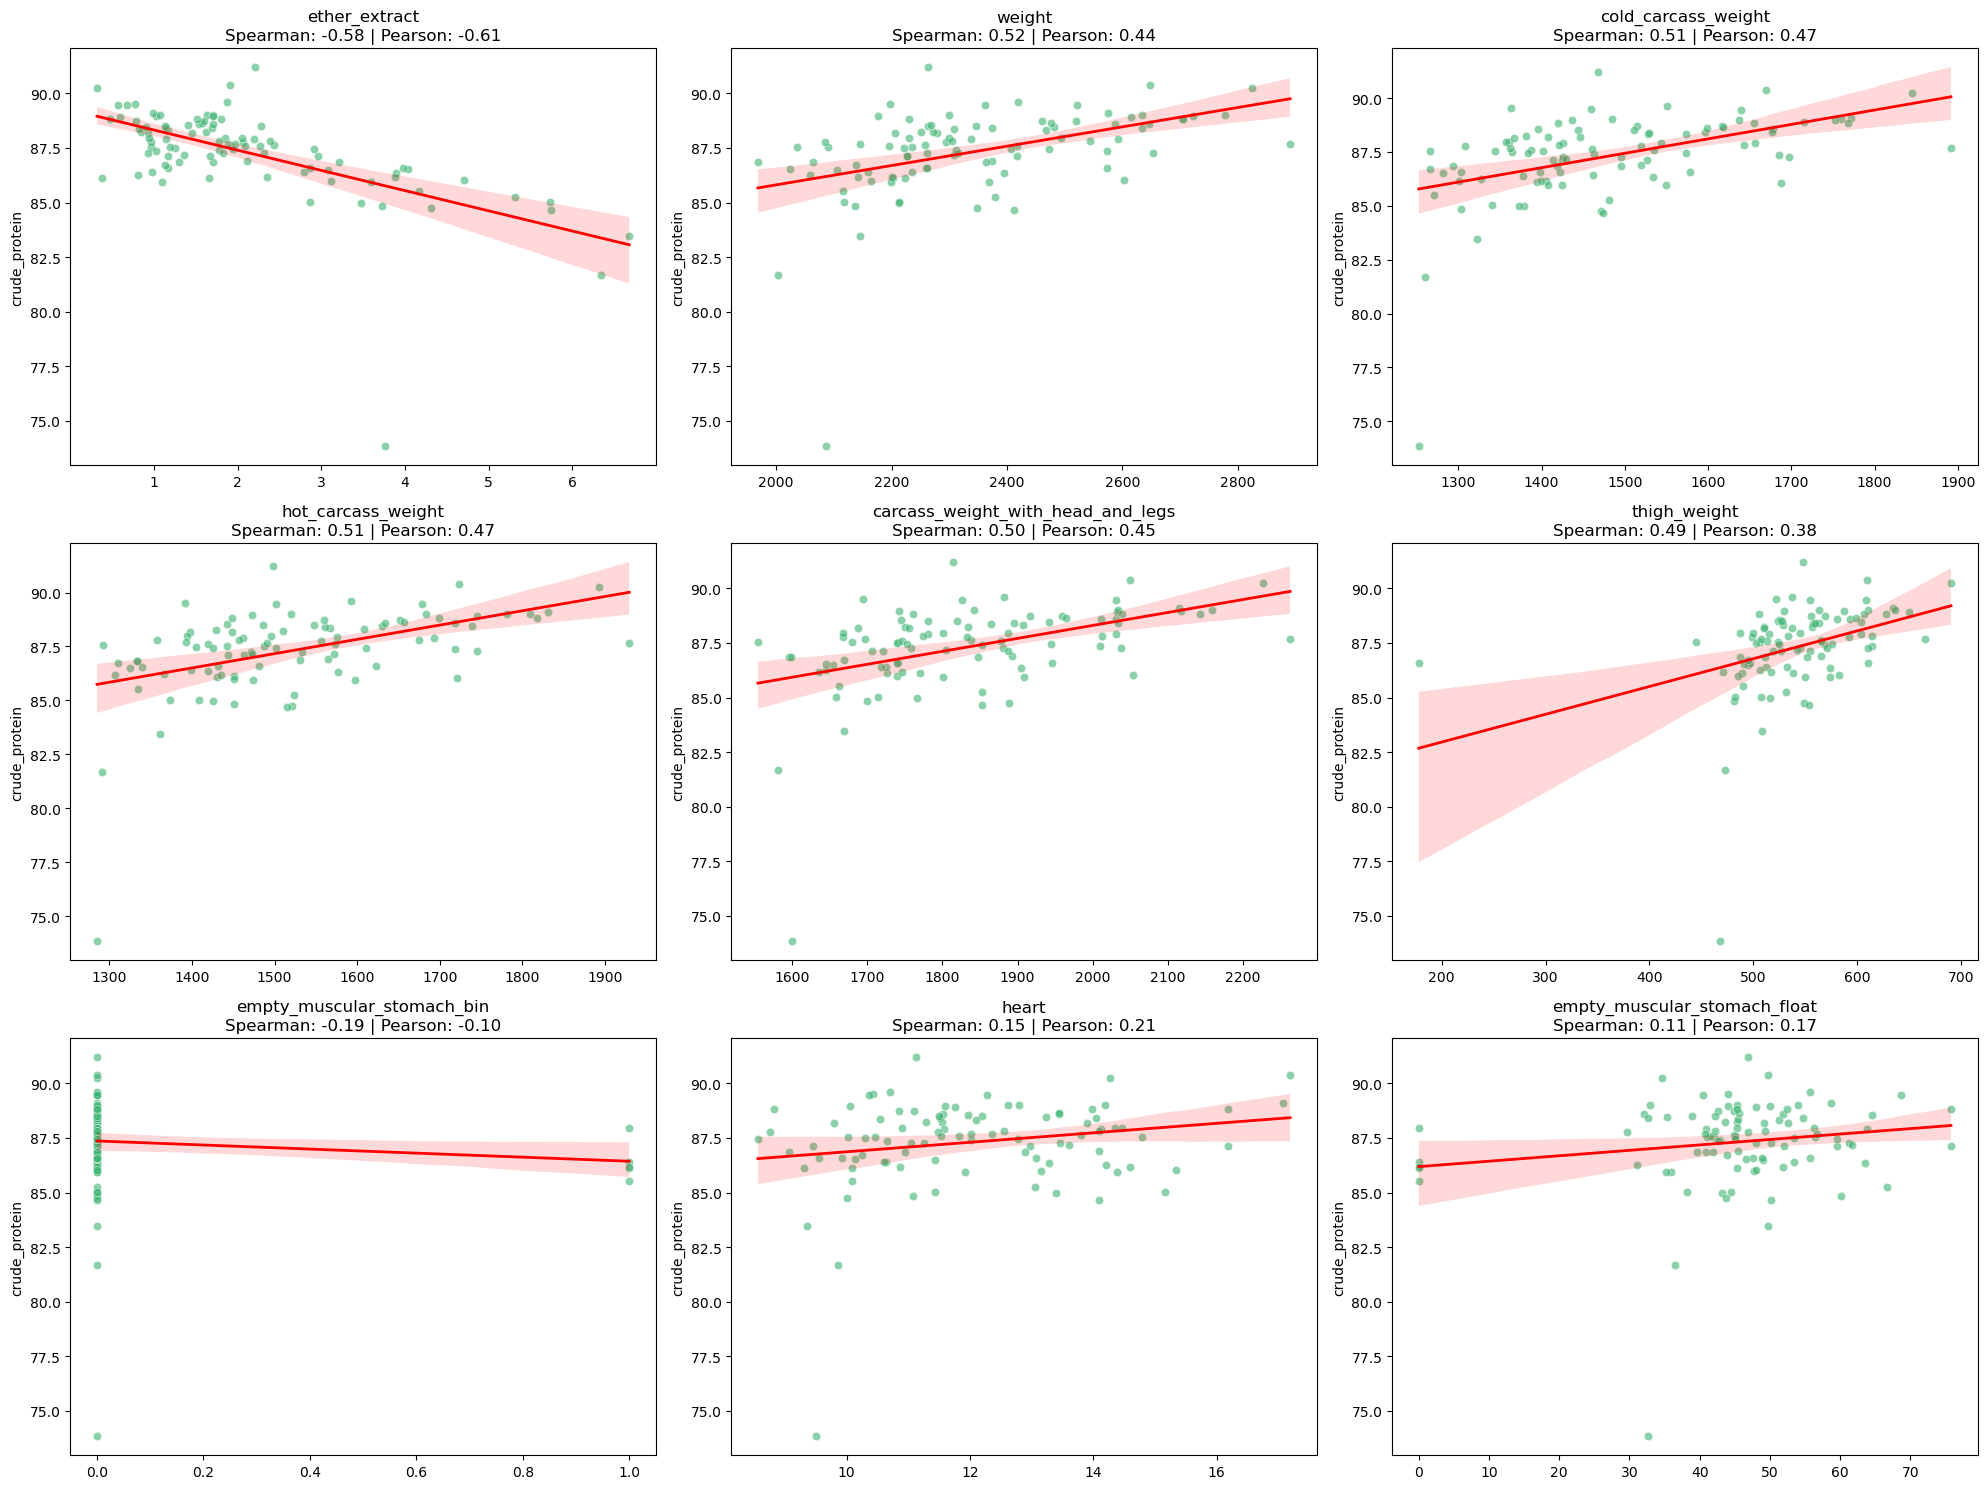

Correlations with crude_protein:


,spearman,pearson
feature,,
ether_extract,-0.582762,-0.612023
weight,0.519340,0.435335
cold_carcass_weight,0.509838,0.467681
hot_carcass_weight,0.508193,0.466773
carcass_weight_with_head_and_legs,0.498589,0.446827
thigh_weight,0.485786,0.379469
empty_muscular_stomach_bin,-0.190323,-0.101427
heart,0.153040,0.205162
liver,0.145050,0.123440


In [21]:
#code adapted from previous work

# correlations with crude_protein
target = 'crude_protein'
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col != target] 

# both correlation types
corr_data = df[features + [target]]  # Note: target needs to be in a list
spearman_corr = corr_data.corr(method='spearman')[target]
pearson_corr = corr_data.corr(method='pearson')[target]

# Combine into a DataFrame for easier analysis
corr_df = pd.DataFrame({
    'feature': features,
    'spearman': spearman_corr[features],
    'pearson': pearson_corr[features]
}).sort_values(by='spearman', key=abs, ascending=False)

# Set threshold (adjust as needed)
threshold = 0.15
significant_features = corr_df[(abs(corr_df['spearman']) >= threshold) | 
                             (abs(corr_df['pearson']) >= threshold)]

# Plot settings
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
if num_features > 0:  # Only proceed if there are significant features
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Ensure axes is always 2D

    # Plot each significant feature against target
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax = axes[i//num_cols, i%num_cols]
        feature = row['feature']
        
        # Scatterplot
        sns.scatterplot(x=df[feature], y=df[target], ax=ax, color='mediumseagreen', alpha=0.6)
        
        # Regression line if possible
        if df[feature].nunique() > 1:
            try:
                sns.regplot(x=df[feature], y=df[target], ax=ax, 
                            scatter=False, color='red', line_kws={'linewidth':2})
            except:
                pass
        
        # Add correlation info to title
        ax.set_title(f"{feature}\nSpearman: {row['spearman']:.2f} | Pearson: {row['pearson']:.2f}")
        ax.set_xlabel('')
        ax.set_ylabel('crude_protein')

    # Hide empty subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Show correlation table
    corr_df = corr_df.set_index('feature')
    print("Correlations with crude_protein:")
    display(corr_df.style.background_gradient(cmap='BuGn', vmin=-1, vmax=1))
else:
    print(f"No features found with correlation >= {threshold}")

When  picking features for modeling, it's crucial to give a special focus on those that have the strongest correlation with the target variable, since they tend to boost predictive performance the most.

In this scenario, features like ether_extract, weight, cold_carcass_weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and thigh_weight stand out with the highest correlation to the target, making them key candidates for inclusion. 

But just because a feature has a high correlation doesn’t mean thy are useless, features that might seem less significant on their own—like heart, liver, or breast_weight—can still bring value when paired with others, especially in non-linear models or when considering interaction effects. So, while the strongest features lay a solid groundwork, it’s wise not to overlook the weaker ones too quickly without doing some additional testing in the modeling process.

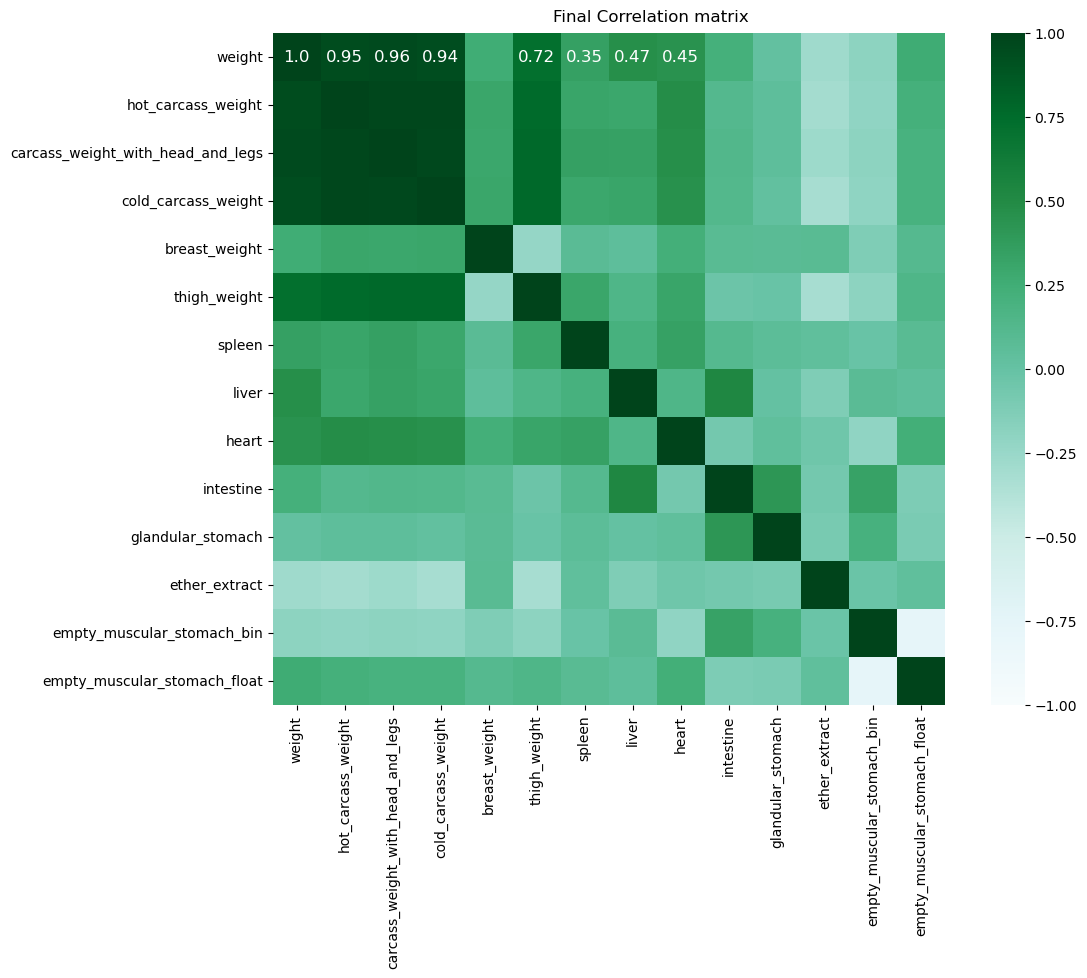

In [22]:
corr = df[features].corr().round(2)
fig = plt.figure(figsize=(12, 8))

# annotation matrix - values above |0.3| will appear in the plot
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape, ''))
sns.heatmap(data = corr, annot = annot, cmap = 'BuGn', fmt = 's', vmin = -1, vmax = 1, center = 0, square = True, linewidths = 0, annot_kws = {'size': 12})

fig.subplots_adjust(top = 0.95)
fig.suptitle('Final Correlation matrix');

The correlation matrix reveals some strong linear relationships among various variables, which points to possible redundancy in the dataset:

- For example, weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and cold_carcass_weight are all highly correlated with each other, with values ranging from 0.94 to 0.98, very high. This indicates that including all four in a model or analysis could lead to multicollinearity issues.

- So, to simplify, we might want to keep just one representative variable—like hot_carcass_weight—and leave the others out.. Similarly, thigh_weight has a strong correlation with the carcass weights (up to 0.77), suggesting it could also be somewhat redundant if we already have carcass weight in the mix.



We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

In [23]:
df['empty_muscular_stomach'] = df['empty_muscular_stomach_bin'] 

In [24]:
df = df.drop(columns=['empty_muscular_stomach_float', 'empty_muscular_stomach_bin'])

`IMPORTANT:`the project description spcifically says "predict the crude protein weight using the remaining features in the dataset, excluding the animal ID." so we corrected the `empty_muscular_stomach` but we will not perform feature selection at this stage, basically we ll have this initial approach were we will test the models with all the features. If futher instructions state otherwise we will follow the analysis above.

### <a id="method-selection"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Choosing the method and parameters for each model</h3>
</div>

[Back to Index](#idx)

- [1. Nested cross-validation vs. Monte Carlo cross-validation](#method) 
- [2. Genetic Programming (GP)](#gp) - Delivery 1 (Done)
- [3. Geometric Semantic Geometric Programming (GSGP)](#gsgp) - Delivery 2 (Done)
- [4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)](#slim) - Delivery 3 (Done)
- [5. Neural Network (NN)](#nn)
- [6. NeuroEvolution of Augmenting Topologies (NEAT)](#neat)

#### <a id="method"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">1. Nested cross-validation vs. Monte Carlo cross-validatio</h4>
</div>

[Back to Index](#idx)

In this project, we opted for **nested cross-validation (nested CV)** as our dataset partitioning strategy for both model selection (hyperparameter tuning) and performance evaluation.

This decision was based on the following considerations:

1. **Final Comparative Evaluation Across Algorithms**  
   At the end of the project, _"the same partitions should be used across all the algorithms to be studied"_, we will compare Genetic Programming (GP) and Geometric Semantic Genetic Programming (GSGP) and other machine learning algorithms.  
   To ensure a **fair and unbiased comparison**, the **same dataset partitions** must be used across all algorithms (are all evaluated under the same conditions basically) - Nested CV provides a systematic and reproducible way to maintain this consistency.

2. **Separation of Concerns: Tuning vs. Evaluation**  
   Nested CV explicitly separates the hyperparameter optimization (inner loop) from the model evaluation (outer loop).  
   This avoids **information leakage** and reduces the risk of **overfitting during model selection**, which is particularly relevant for algorithms like GP that are prone to overfitting and premature convergence.
   "the advantage of doing several iterations in cross-validation is that it allows us to obtain an error estimate that is not dependent on a single data splitting and a particular choice of the training data"_ (Vanneschi & Silva, Sec. 5.3, p.130). Nested CV extends this robustness by adding an inner loop for model selection, which further reduces the risk of biased or optimistic performance estimation.

3. **Avoiding Pitfalls of Monte Carlo CV in This Context**
   Although Monte Carlo cross-validation (or repeated random subsampling) can be viewd as an alternative (Vanneschi & Silva, p.130-131), it comes with a notable limitation: _"some observations may never be selected for the test set, while others will be selected more than once"_. In this project, where a **comparative and reproducible evaluation across multiple algorithms is required**, this irregularity makes Monte Carlo CV less appropriate than nested CV.  Using a **K-Fold outer loop** (e.g., `K=10`) ensures that every instance in the dataset is used for testing exactly once, and for training K-1 times, and combined with an **inner K-Fold** (e.g., `K=5`) for tuning, this strategy enables robust **statistical comparisons** (e.g., Wilcoxon tests, Friedman + Nemenyi post-hoc), which are essential to draw valid conclusions about performance differences between models.

   The  different CV strategies may be appropriate for different phases: _"it may make sense to use 5-fold or 10-fold cross-validation for choosing the method and parameters (...) and then use Monte Carlo (...) for a thorough estimation of the error"_ (p.131).  
   However, since our pipeline includes both tuning and evaluation as part of the **same CV process**, and comparison across methods is the final goal, we apply nested CV consistently for both.

4. Despite the relatively small size of our dataset (96 instances), we argue that nested cross-validation remains a justified choice. As pointed out by Vanneschi & Silva (Section 5.3), the reliability of performance estimation is a crucial concern when data is scarce. Nested CV is particularly effective in avoiding overfitting during hyperparameter tuning, which becomes even more critical under these circumstances.

The training and test sets generated in each fold still preserve enough data to fit and evaluate meaningful models. Moreover, since the dataset is small, the computational overhead introduced by nested CV is negligible.

In summary, while some may consider using Monte Carlo cross-validation to reduce computational cost or avoid small folds, the benefits of using nested cross-validation — particularly in terms of fair model selection and unbiased generalization error estimation — outweigh the drawbacks, especially when working with limited data.


In [25]:
target = 'crude_protein'
X = df.drop(columns=[target])
y = df[target]

In [26]:
k_outer = 5
k_inner = 3
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=seed)

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



- Dataset size: 96 samples -> GP can overfit easily on small data if trees get too big or the population too complex

In [27]:
# ===================== Nested CV Generator =====================
def nested_cv_generator(X, y, k_outer=10, k_inner=3, random_state=None):
    """ https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/"""
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)
    for outer_train_idx, outer_test_idx in outer_cv.split(X):
        X_outer_train = X.iloc[outer_train_idx].reset_index(drop=True)
        y_outer_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)

        inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=random_state)
        inner_splits = list(inner_cv.split(X_outer_train))

        yield {
            'X_outer_train': X_outer_train,
            'y_outer_train': y_outer_train,
            'X_test': X_test,
            'y_test': y_test,
            'inner_splits': inner_splits,
        }

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">2. Genetic Programming (GP)</h4>
</div>

[Back to Index](#idx)

> since this delivery i about GP we will keep this massive code in here to be easier to evaluate but in the final project we will do it in python file and import the function (if its ok of course) to make the notebook cleaner

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `max_depth`          | `[10]`                                             | Limits the model's complexity. Deep trees overfit easily on small datasets. Capping depth avoids bloated or overly specific programs.           |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `30`                                                  | Reasonable trade-off between computation and convergence. Too many iterations with small data can lead to overfitting.                          |


Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

> Running GP with Best Config  

Although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

**Per fold Analysis: Overfitting, Bloat and Premature Convergence**

- **Outer Fold 1**

This fold showed some interesting early behavior. The algorithm converged too quickly, locking onto a solution by the second generation. Training fitness dropped from 1.03 to 0.94 right away, then had small variations for the rest of the 30 generations. That kind of 'stagnation' can mean the population lost diversity early on and didn’t explore better parts of the solution space.

There was also a hint of overfitting between generations 5 and 7—training error kept going down, but test error briefly spiked above 1.12. but in generation 10, both errors settled around 0.73, showing the model found a decently generalizable solution.

As for **bloat**, there wasn’t any. The tree sizes stayed small and consistent, growing from 5 to 7 nodes early on and holding steady -> That’s a good sign the model was penalizing complexity.


- **Outer Fold 2**

After the first generation, test fitness dropped and went around 0.4125.. by generation 11. We thibnk the model got stuck in a local minimum or converged too early, and the training fitness kept improving slightly, which again hints at some overfitting.

Tree size didn’t grow—it stayed at 5 nodes during the plateau—so the model didn’t try to increase complexity to escape the stagnation. Still, it predicted reasonably well overall, with a final RMSE of 0.8379, which isn’t bad.


- **Outer Fold 3**

This one struggled, the training fitness got better (0.7010), the test fitness stayed high—around 1.6185. This shows overfitting as the model learned the training data but failed to generalize at all. On top of that, bloat became a problem bc the trees ballooned to 29 nodes by the end, the model added to much complexity and that extra complexity didn’t help. 

Outliers in the test data, like a very low crude protein value of 73.84, probably made things worse. Since we used the robust scaler this should had helped. This extra complexity can also indicate that we have too much features and the model tries too hard to learn all the patterns, a feature selection can maybe imporve this.

- **Outer Fold 4**

This fold saw a consistent reduction in training and test fitness at the beginning, so the model was learning at first. Training error declined from 0.998 to 0.857 and test error declined from 0.77 to 0.52 from generation 0 to generation 5 wich is a positive indicators of convergence. But after generation 6 train fitness fell into a stagnation phase and test started to get worse stabilizing at gen 12.Again, this suggests premature convergence the population could have lost diversity or wasn't under evolutionary pressure to escape the local optima.

There is a faint sign of overfitting after generation 12 and the model still explores more extensive trees -> node size grows from 9 to 31, and this added complexity did not contribute to generalization as the test fitness actually get worse.5198. So this inconsistency among increased complexity and worsening test performance is evidence of mild overfitting.

In terms of Bloat is obviasly more severe in this case. The early trees were tiny (5–11 nodes), but the model tried a 49-node tree in generation 8, and then stuck with bloated 31-node trees for no improvement in fitness. So, bloat without benefit, more complexity, but not better performance.

- **Outer Fold 5**

This fold showed early convergence, with improvements in training / test fitness over several generations. From generation 0 to 3, test fitness dropped from 0.8197 to 0.5241. But from generation 6 onwards, the model actually ceased to get better altogether —> a sure indication of premature convergence.

Bloat was completely avoided here. The model continued to hold a very small 3-node tree from generation 1 to generation 30. Although this is excellent at controlling complexity, it is also indicative of lacking exploration, and the model might have only settled on very shallow solution that was "good enough" and never moved further beyond.

Overfitting was small, good generalization with no significant gap between training and testing fitness.



**Final notes for GP**: So this solution needs some improvment to generalize better and avoid overcomplicate the size of the solution, our best approach would be to perfom feature selecion to try to help the model not to focus in every patter and generalize better, at the same time avoiding multicollinearity and features that add noise moree noise than help to the prediction.

#### <a id="gsgp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">3. Geometric Semantic Geometric Programming (GSGP)</h4>
</div>

[Back to Index](#idx)

> since this delivery i about GSGP we will keep this massive code in here to be easier to evaluate but in the final project we will do it in python file and import the function (if its ok of course) to make the notebook cleaner

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `[10, 15]`                                                  | Has to be lower than in regular GP, given that there is no maximum depth GSGP tends to bloat very quickly                        |
| `reconstruct`             | `True`                                                  | GSGP requires this parameter to store the trees' structure to construct the new generation                        |

Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

> GSGP best configuration

`Geral Notes:` We notice that using a large population size or a high number of iterations in GSGP lead to a significant bloating, doing some research lead to the conclusion that since its generation introduces new semantic components without reducing the complexity of the existing structure this is normal so to reduce the big node count we used a smaller initial population and generations. 

Also, like for GP, although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

- **Outer Fold 1 and Outer Fold 2 (More bloat in this one beacause the model tried to excape local opt more than one time)**

This fold initially performed quite well, showing promise in the early generations, it converged on generation 9. But, at the beginning, from generation 0 to 3, the test fitness drooped from 0.94 → 0.62 and training fitness from 0.94 → 0.83, and then in generation 4, the model began to overfit → the training fitness kept decreasing, but the test fitness did increase a bit 0.62 → 0.78 → 0.75.This suggests the model failed to generalize better despite training improvements.

Bloat was significant but the gsgp model is also more prone to that, we did have imporvements with some adjustments we did during the tunning, specifically experimenting with poppulation and interaction sizes, but we can explore that further. The increased complexity started when the signs of overfitting appear so we conclude that the model tried to increase complexity to improve the test score but without benefit from it.

Basically the model found a good region early but lacked mechanisms to control complexity or escape local optima.

- **Outer Fold 3**

This was the worst-performing fold in terms of rmse  so far, like in gp this fols with the low test value of 73 usually leads to problems, in this case the model converged early in gen 4/5 and then started to increase complexity / bloat to try to escape this lcocal optima, in the end did imporve a little bit but the trade off btw complexity and and the score was not worthed.

Training fitness, on the other hand, kept improving (0.76 → 0.45), indicating overfitting.

- **Outer Fold 4**

Again, it converged early in generations 4/5 and like in the other folds it started to add complexity to escape this local opt leading it to bloat, it did converged again on generation 9 but the score is worse than in generation 5, and since the training kept decreasing we can conclude the existance of overfitting. 

In the end, this fold demonstrates one of the best trade-offs between accuracy and complexity.

- **Outer Fold 5**

Similar thing happen in this fold, but the model was able to escape the local optmia with the increased bloat.



#### <a id="slim"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)</h4>
</div>

[Back to Index](#idx)

We already talked abou the other parameters above but for slim specific parameters:

| **Parameter**  | **Test Values**                                                                | **Why?**                                                                                                                                    |
| -------------- | ------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------- |
| `slim_version` | `['SLIM+SIG2', 'SLIM+SIG1', 'SLIM+ABS', 'SLIM*SIG2', 'SLIM*SIG1', 'SLIM*ABS']` | These cover both the standard and modified variants of SLIM with different mutation strategies, giving a broad view of performance impacts. |
| `p_inflate`    | `0.5`                                                                          | A balanced value to give equal chances to inflate and deflate mutations, supporting diverse structural exploration.                         |
| `copy_parent`  | `True`, `False`                                                                | `True` helps preserve valid individuals when mutation fails (good for stability). `False` increases selection pressure by discarding them.  |




> We originally tested over 300 parameter combinations during the tuning phase. However, since re-running all of them would be extremely time-consuming, we narrowed the parameter space to include only the most promising configurations. For example, we found that using 20 generations consistently produced suboptimal results across all folds, so we excluded it. Also, an initial tree depth of 3 performed better than depth 5 that often led to higher and more inconsistent boxplot distributions. We also tested a population size of 30, but it didn't offer any advantage and was removed as well. The final set of parameters reflects those that showed more consistent and efficient performance (in this way is more manageable to run this notebook again for the evaluation).

> SLIM best configuration

we can see that the size stabilized after the gen 30. 

Like for GP and GSGP, although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

- **Outer Fold 1**

The model tries to escape a local optima right after the generation 1, incresing the node count to 20, this lead to the increase of complexity without benefit in terms of test performance since, althought the train fitness kept decreasing, the test fitness gave us a hint of overfitting since it start increasing from 0.73 to 0.77, an later after a considerate bloat reaching 46 nodes it increased again when the model started o decrease the node count. The model gets stuck with no further improvement in test fitness and minimal changes in train fitness (at 0.7847) at generation 17, the node count stabilizes at 35 nodes, slightly lower than the peak we reffer but still significantly bloated compared to the starting point -> this plateau suggests early convergence and persistent overfitting. The fitness values remain constant for over 30 generations.

As an overfitting evidence, tthe predicted values clustered tightly around the central values ~82–89, while the real values had more spread from 82 to 91, showing a loss of nuance in prediction — again a sign the model over-learned patterns from training data and failed to generalize well.

The model found a moderately promising region by generation 3 but lacked mechanisms (like parsimony pressure or semantic simplification) to control bloat or escape its local optimum, and the small improvement in predictions in gen 17 did not justify the increasing complexity.


- **Outer Fold 2**

Similiar behaviour to fold 1 at the beginning, the model initially shows signs of overfitting early on, as it increases in complexity/ node count jumping from 5 to 31 by generation 13 without significant gains in test performance. After a brief improvement until generation 19, where test fitness reaches its best value, the model the model tries to escape this optima invreasing the complexity and enters a prolonged plateau with no further gains, in fact the worse performance is reached here, despite increasing complexity to 48 nodes. This extended stagnation over 15 generations shows a classic bloat and overfitting behavior, where additional structure only improves train fitness while test performance keps getting worse or has no improvements. It ended with a worse fitness when considering the test set.

- **Outer Fold 3**

This fold was very straightforward, at generation 14 it was able to reach the best test fitness with less complexity, but since it tried to escape the local optima it end up increasing the model complexity at generation 25, with a slight decrease in test fitness. So the early convergence made the model tried to escape the local minimum and this actually led to a decrease in generalization (overfitting sincce the trin score kept decreasing) and more complexity, wich is not good. This is also proven since we can see the predictions cannot reach the real value of 73 althought the predicted value was the lowest in this case (84).

- **Outer Fold 4**

Again, very similiar the model tries to escape the local optima after a early convergence at generation 5 -> 0.47, reaching the best test fitness at this stage with 33 nodes, althought the model is able to get back from the decrease in test fitness and increased bloating from generation 9 to 41, at generation 42 it goes back to 33 nodes but with a slightly higher rmse -> 0.49. the train fitness kept decreasing and converged on this same generation 42, indicating overfitting since the test did get worse from the local optima at the beginning.

- **Outer Fold 5**

This fold clearly illustrates the core issue with the model -> early convergence followed by unsuccessful attempts to escape a local optimum. After an initial phase where a decent test fitness is achieved with low complexity, the model begins to overfit, increasing node count significantly to improve training fitness while test performance stagnates or worsens. Despite stabilizing the node count in later generations, the model continues to focus on optimizing training fitness, which results in poor generalization. This persistent overfitting, combined with unnecessary bloat, mirrors the inefficiencies seen across the other folds.


**Final notes**: 

Across all five folds, the model consistently exhibits early convergence followed by attempts to escape local optima through increased complexity (bloat). These attempts often result in overfitting, where training fitness improves at the cost of test performance. The model lacks mechanisms to effectively regulate complexity, such as parsimony pressure or semantic guidance, leading to unnecessarily bloat with minimal or negative gains in generalization. Predictions tend to cluster narrowly around central values, failing to capture the full range of real outputs, another indicator of overfitting. The folds collectively show that while the model can initially identify promising regions of the search space, its inability to control bloat or maintain generalization ultimately limits its performance.

So this solution needs some improvment to generalize better and avoid improving the train fitness at the expense of the test fitness, our best approach would be to perfom feature selecion to try to help the model not to focus in every patter and generalize better, at the same time avoiding multicollinearity and features that add noise moree noise than help to the prediction. We tested with less generations and the problem still persisted. 

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">4. Neural Network (NN)</h4>
</div>

[Back to Index](#idx)

In [28]:
import torch.nn as nn
import torch.optim as optim

In [29]:
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, attribute):
        if isinstance(attribute, nn.Linear):
            torch.nn.init.xavier_uniform_(attribute.weight)
            torch.nn.init.zeros_(attribute.bias)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
def rmse_loss(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    return rmse

def nn_fitness(model, data, targets):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        loss = rmse_loss(predictions, targets)
    return loss.item()

In [31]:
def initialize_population(pop_size, input_size, hidden_sizes, output_size):
    population = []
    for _ in range(pop_size):
        model = CustomNN(input_size, hidden_sizes, output_size)
        population.append(model)
    return population


def elitist_select(population, fitness_values, num_parents):
    selected = np.argsort(fitness_values)[:num_parents]
    return [population[i] for i in selected]

def tournament_selection(fitness_population, tournament_size):
    i_best = random.sample(range(len(fitness_population)), 1)[0]
    for _ in range(1, tournament_size):
        i_selected = random.sample(range(len(fitness_population)), 1)[0]
        if fitness_population[i_best] > fitness_population[i_selected]:
            i_best = i_selected
    return i_best

def get_best(fitness_population):
    return np.argsort(fitness_population)[0]

def get_worst(fitness_population):
    return (-np.array(fitness_population)).argsort()[0]

def elitism(parents, fitness_parents, offspring, fitness_offspring):
    i_best_parent = get_best(fitness_parents)
    i_best_offspring = get_best(fitness_offspring)
    if fitness_parents[i_best_parent] < fitness_offspring[i_best_offspring]:
        i_worst = get_worst(fitness_offspring)
        offspring[i_worst] = parents[i_best_parent]
    return offspring

def evolve(
    population, generations,
    data, targets, data_test, targets_test,
    mutation_rate=0.01, mutation_noise=0.1, node_mutation_rate=0.2, 
    population_size=10,
    tournament_size=2):

    rmse_train_history = []
    rmse_test_history = []
    rmse_train_previous = 1e5
    
    for generation in tqdm(range(generations)):
        
        # Population
        fitness_values = [nn_fitness(model, data, targets) for model in population]
        next_population = []

        while len(next_population) < population_size:
            # Select parent 1
            parent_1 = tournament_selection(fitness_population=fitness_values, tournament_size=tournament_size)
            # fitness_values = [nn_fitness(model, data, targets) for model in population]
            # print('fitness_values {}'.format(fitness_values))
    
            # Apply mutation adding offspring to next population
            if random.random() < mutation_rate:
                next_population.append(mutate(copy.deepcopy(population[parent_1]), mutation_noise, node_mutation_rate))
                # print('Mutation')
                # fitness_values = [nn_fitness(model, data, targets) for model in population]
                # print('fitness_values {}'.format(fitness_values))
                # i_elite = get_best(fitness_values)
                # rmse_train = fitness_values[i_elite]
                # print('fitness best pop {}'.format(fitness_values[get_best(fitness_values)]))
                
                # fitness_values = [nn_fitness(model, data, targets) for model in next_population]
                # print('fitness best NEXT pop {}\n'.format(fitness_values[get_best(fitness_values)]))
                # print('fitness_values {}\n'.format(fitness_values))
        
            else:
                # Otherwise, apply XO adding offspring to next population
                parent_2 = tournament_selection(fitness_population=fitness_values, tournament_size=tournament_size)
                next_population.append(crossover(
                    copy.deepcopy(population[parent_1]), copy.deepcopy(population[parent_2])
                ))
                # fitness_values = [nn_fitness(model, data, targets) for model in population]
        
        # Apply elitism and replace population
        fitness_parents = copy.deepcopy(fitness_values)
        fitness_offspring = [nn_fitness(model, data, targets) for model in next_population]
        population = elitism(
            parents=population, fitness_parents=fitness_parents,
            offspring=next_population, fitness_offspring=fitness_offspring
        )

        # Log
        fitness_values = [nn_fitness(model, data, targets) for model in population]
        i_elite = get_best(fitness_values)
        rmse_train = fitness_values[i_elite]
        rmse_test = nn_fitness(population[i_elite], data_test, targets_test)
        rmse_train_history.append(rmse_train)
        rmse_test_history.append(rmse_test)
        rmse_train_previous = rmse_train
        
    # Return
    # fitness_values = [nn_fitness(model, data, targets) for model in population]
    return (population[get_best(fitness_values)], rmse_train_history, rmse_test_history)
    

In [32]:
# 100% do chat

def crossover(model1, model2):
    child_model = CustomNN(model1.fc1.in_features, [model1.fc1.out_features, model1.fc2.out_features], model1.fc3.out_features)
    
    with torch.no_grad():
        for child_param, param1, param2 in zip(child_model.parameters(), model1.parameters(), model2.parameters()):
            child_param.copy_((param1 + param2) / 2.0)
    
    return child_model

def mutate(model, mutation_noise=0.1, node_mutation_rate=0.2):
    child_model = copy.deepcopy(model)
    
    with torch.no_grad():
        for param in child_model.parameters():
            if random.random() < node_mutation_rate:
                noise = torch.randn_like(param) * mutation_noise
                param.add_(noise)
    
    return child_model



In [33]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

def nested_cv_nn(
    X, y, param_grid, k_outer=5, k_inner=3, dataset_name="Chicken", gp_class=None, seed=42, alpha_sig=0.05
):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    outer_scores = []
    best_grid_models = []
    validation_results = []  # This will store detailed results for analysis
    detailed_results = []  # New: will store all fold results for all configs

    os.makedirs("./log/GP/", exist_ok=True)

    keys, values = zip(*param_grid.items())
    param_combos = [dict(zip(keys, v)) for v in product(*values)]

    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer=k_outer, k_inner=k_inner, random_state=seed)):
        print(f"\n========== OUTER FOLD {fold_idx+1}/{k_outer} ==========")

        best_config = None
        best_val_score = float('inf')
        all_inner_fold_scores = []  # will be list of [k_inner] RMSEs per config

        # ============ Grid Search on Inner CV ============ #
        for config_id, flat_config in enumerate(param_combos):
            # gp_config = {
            #     'initializer': flat_config['initializer'],
            #     'sspace': {
            #         'p_constants': flat_config['sspace.p_constants'],
            #         'max_init_depth': flat_config['sspace.max_init_depth'],
            #         'max_depth': flat_config['sspace.max_depth'],
            #         'tree_constants': flat_config['sspace.tree_constants'],
            #     },
            #     'pop_size': flat_config['pop_size'],
            #     'xo_prob': flat_config['xo_prob'],
            #     'generations': flat_config['generations'],
            #     'seed': seed
            # }

            inner_fold_rmses = []

            for inner_fold_idx, (inner_train_idx, inner_val_idx) in enumerate(fold_data['inner_splits']):
                X_train = fold_data['X_outer_train'].iloc[inner_train_idx]
                y_train = fold_data['y_outer_train'].iloc[inner_train_idx]
                X_val = fold_data['X_outer_train'].iloc[inner_val_idx]
                y_val = fold_data['y_outer_train'].iloc[inner_val_idx]

                # Scaling
                x_scaler = RobustScaler()
                y_scaler = RobustScaler()
                X_train_scaled = x_scaler.fit_transform(X_train)
                X_val_scaled = x_scaler.transform(X_val)
                y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

                # Tensors
                X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

                # Model training
                # model = gp_class(
                #     X_train=X_train_tensor, y_train=y_train_tensor,
                #     X_test=X_val_tensor, y_test=y_val_tensor,
                #     dataset_name=dataset_name,
                #     fitness_function='rmse',
                #     minimization=True,
                #     initializer=gp_config['initializer'],
                #     tree_constants=gp_config['sspace']['tree_constants'],
                #     tree_functions=['add', 'subtract', 'multiply', 'divide'],
                #     prob_const=gp_config['sspace']['p_constants'],
                #     init_depth=gp_config['sspace']['max_init_depth'],
                #     max_depth=gp_config['sspace']['max_depth'],
                #     pop_size=gp_config['pop_size'],
                #     p_xo=gp_config['xo_prob'],
                #     elitism=True,
                #     n_elites=1,
                #     tournament_size=2,
                #     n_iter=gp_config['generations'],
                #     test_elite=True,
                #     log_level=0,
                #     verbose=0,
                #     n_jobs=1,
                #     seed=gp_config['seed']
                # )
                model = CustomNN(X.shape[1], flat_config['hidden_sizes'], 1)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=0.01)

                for epoch in range(flat_config['generations']):
                    model.train()
                    optimizer.zero_grad()
                    output = model(X_train_tensor).squeeze()
                    loss = criterion(output, y_train_tensor)
                    loss.backward()
                    optimizer.step()

                model.eval()

                # Evaluation
                with torch.no_grad():
                    y_pred = model(X_val_tensor).squeeze().numpy().reshape(-1, 1)
                    y_true = y_val_tensor.numpy().reshape(-1, 1)
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    inner_fold_rmses.append(rmse)
                    
                    # Store detailed results for this fold and config
                    detailed_results.append({
                        'outer_fold': fold_idx + 1,
                        'inner_fold': inner_fold_idx + 1,
                        'config_id': config_id,
                        'config': str(flat_config),  # String representation
                        'rmse': rmse
                    })

            avg_val_rmse = np.mean(inner_fold_rmses)
            all_inner_fold_scores.append(inner_fold_rmses)

            print(f"  Config {config_id+1}/{len(param_combos)} | Inner Mean RMSE: {avg_val_rmse:.4f}")

            if avg_val_rmse < best_val_score:
                best_val_score = avg_val_rmse
                best_config = flat_config

        print(f"\n✅ Best config for outer fold {fold_idx+1}:")
        print(best_config)
        print(f"Best inner RMSE: {best_val_score:.4f}")
        best_grid_models.append(best_config)

        # Convert to DataFrame for statistical tests
        df_inner_scores = pd.DataFrame(all_inner_fold_scores).T  # shape: (k_inner, n_configs)
        validation_results.append(df_inner_scores)

        # ============ Statistical Tests ============ #
        print("\nStatistical test on inner fold scores:")
        stat, p = friedmanchisquare(*[df_inner_scores[col] for col in df_inner_scores.columns])
        print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")
        if p < alpha_sig:
            posthoc_result = sp.posthoc_nemenyi_friedman(df_inner_scores.to_numpy())
            significant_columns = posthoc_result.columns[posthoc_result.lt(0.05).any(axis=0)]
            filtered_result = posthoc_result[posthoc_result < alpha_sig]
            filtered_result = filtered_result.dropna(how='all').dropna(axis=1, how='all').fillna('-')
            print("P-values of significant differences:")
            print(filtered_result)
        else:
            print("No significant differences found between configs.")

        # ============ Boxplot ============ #
        # Convert detailed results to DataFrame for this outer fold
        df_fold_results = pd.DataFrame([r for r in detailed_results if r['outer_fold'] == fold_idx + 1])
        
        # Create labels for configurations
        config_labels = {
            i: f"Config {i+1}<br>" + "<br>".join(
                [f"{k}: {v}"[:30] for k, v in param_combos[i].items()]  # Corta cada item em 30 chars
            )
            for i in range(len(param_combos))
        }
        df_fold_results['config_label'] = df_fold_results['config_id'].map(config_labels)

        fig = go.Figure()
        fig.add_trace(go.Box(
            x=df_fold_results['config_label'],
            y=df_fold_results['rmse'],
            fillcolor='rgba(108, 140, 200, 0.3)',
            line=dict(color='rgba(108, 140, 200, 1)'),
            boxpoints='all',
            jitter=0,
            pointpos=0,
            marker=dict(color='rgba(108, 140, 200, 1)')
        ))
        fig.update_layout(
            title=f'Inner CV RMSEs - Outer Fold {fold_idx+1}',
            yaxis_title='Validation RMSE',
            width=200 * len(param_combos),
            height=400,
            plot_bgcolor='#f1f1f1',
            xaxis_tickangle=-90,
            margin=dict(l=50, r=50, t=50, b=20),
            showlegend=False
        )
        fig.show()


        # ============ Retrain on Outer Train, Evaluate on Outer Test ============ #
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_outer_train_scaled = x_scaler.fit_transform(fold_data['X_outer_train'])
        X_test_scaled = x_scaler.transform(fold_data['X_test'])
        y_outer_train_scaled = y_scaler.fit_transform(fold_data['y_outer_train'].values.reshape(-1, 1)).flatten()
        y_test_scaled = y_scaler.transform(fold_data['y_test'].values.reshape(-1, 1)).flatten()

        X_outer_train_tensor = torch.tensor(X_outer_train_scaled, dtype=torch.float32)
        y_outer_train_tensor = torch.tensor(y_outer_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        # model = gp_class(
        #     X_train=X_outer_train_tensor, y_train=y_outer_train_tensor,
        #     X_test=X_test_tensor, y_test=y_test_tensor,
        #     dataset_name=dataset_name,
        #     fitness_function='rmse',
        #     minimization=True,
        #     initializer=best_config['initializer'],
        #     tree_constants=best_config['sspace']['tree_constants'],
        #     tree_functions=['add', 'subtract', 'multiply', 'divide'],
        #     prob_const=best_config['sspace']['p_constants'],
        #     init_depth=best_config['sspace']['max_init_depth'],
        #     max_depth=best_config['sspace']['max_depth'],
        #     pop_size=best_config['pop_size'],
        #     p_xo=best_config['xo_prob'],
        #     elitism=True,
        #     n_elites=1,
        #     tournament_size=2,
        #     n_iter=best_config['generations'],
        #     test_elite=True,
        #     log_level=0,
        #     verbose=0,
        #     n_jobs=1,
        #     seed=best_config['seed']
        # )

        model = CustomNN(X.shape[1], best_config['hidden_sizes'], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(best_config['generations']):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_tensor).squeeze()
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            y_pred_scaled = model(X_test_tensor).squeeze().numpy()
            y_pred_rescaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            test_rmse = np.sqrt(mean_squared_error(fold_data['y_test'], y_pred_rescaled))

        print(f"\n[Outer Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)
        gc.collect()

    print(f"\n================ Final Results ================\nMean RMSE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    df_all_results = pd.DataFrame(detailed_results)
    return np.array(outer_scores), best_grid_models, df_all_results, validation_results

In [34]:
# TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
# SLIM_VERSIONS = ['SLIM+SIG2', 'SLIM+SIG1', 'SLIM+ABS', 'SLIM*SIG2', 'SLIM*SIG1','SLIM*ABS']


# Grid of parameters to test
# param_grid = {
#     'initializer': ['grow', 'rhh'],                   
#     'sspace.p_constants': [0.1, 0.5],                
#     'sspace.max_init_depth': [3],                                          
#     'sspace.tree_constants': [TREE_CONSTANTS],        
#     'pop_size': [50],                                                                       
#     'generations': [30, 50],                         
#     'ms_lower': [0],                               
#     'ms_upper': [1],                               
#     'reconstruct': [True],                   
#     'slim_version': SLIM_VERSIONS,                                   
#     'p_inflate': [0.5],                               
#     'copy_parent': [True, False]                            
# }

# input_size = 13 

param_grid = {
    'input_size': [13],
    'hidden_sizes': [[5, 5]], 
    'output_size': [1],
    'population_size': [10],
    'tournament_size': [3],
    'generations': [30, 50],
    'mutation_rate': [0.5, 0.7]
}

# Seeds to test for reproducibility and robustness
seeds = [42, 123, 456]

# Collecting results across seeds
all_scores = []
all_best_models = []
all_results = []
all_validation = []

# Cross-validation loop with multiple seeds
for seed in seeds:
    print(f"\n=== Running with seed: {seed} ===\n")

    # Ensuring reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Run nested cross-validation
    scores, best_models, df_results, val_results = nested_cv_nn(
        X=X, y=y,
        param_grid=param_grid,
        gp_class=slim,
        k_outer=5, k_inner=3,
        seed=seed
    )

    # Store results
    all_scores.append(scores)
    all_best_models.append(best_models)
    all_results.append(df_results)
    all_validation.append(val_results)


=== Running with seed: 42 ===


========== OUTER FOLD 1/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.0860
  Config 2/4 | Inner Mean RMSE: 1.2588
  Config 3/4 | Inner Mean RMSE: 1.0382
  Config 4/4 | Inner Mean RMSE: 1.0581

✅ Best config for outer fold 1:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 50, 'mutation_rate': 0.5}
Best inner RMSE: 1.0382

Statistical test on inner fold scores:
Friedman test statistic: 3.4000, p-value: 0.3340
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 1.8100

========== OUTER FOLD 2/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.0951
  Config 2/4 | Inner Mean RMSE: 1.0084
  Config 3/4 | Inner Mean RMSE: 1.1272
  Config 4/4 | Inner Mean RMSE: 0.9233

✅ Best config for outer fold 2:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 50, 'mutation_rate': 0.7}
Best inner RMSE: 0.9233

Statistical test on inner fold scores:
Friedman test statistic: 5.4000, p-value: 0.1447
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 1.1565

========== OUTER FOLD 3/5 ==========
  Config 1/4 | Inner Mean RMSE: 0.6878
  Config 2/4 | Inner Mean RMSE: 0.6681
  Config 3/4 | Inner Mean RMSE: 0.6611
  Config 4/4 | Inner Mean RMSE: 0.5878

✅ Best config for outer fold 3:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 50, 'mutation_rate': 0.7}
Best inner RMSE: 0.5878

Statistical test on inner fold scores:
Friedman test statistic: 3.4000, p-value: 0.3340
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 3.2178

========== OUTER FOLD 4/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.2584
  Config 2/4 | Inner Mean RMSE: 0.9967
  Config 3/4 | Inner Mean RMSE: 1.0340
  Config 4/4 | Inner Mean RMSE: 1.0095

✅ Best config for outer fold 4:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 0.9967

Statistical test on inner fold scores:
Friedman test statistic: 0.2000, p-value: 0.9776
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 1.4046

========== OUTER FOLD 5/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.2057
  Config 2/4 | Inner Mean RMSE: 1.0073
  Config 3/4 | Inner Mean RMSE: 1.0575
  Config 4/4 | Inner Mean RMSE: 1.1561

✅ Best config for outer fold 5:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 1.0073

Statistical test on inner fold scores:
Friedman test statistic: 5.4000, p-value: 0.1447
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.1074

================ Final Results ================
Mean RMSE: 1.7393 ± 0.7800

=== Running with seed: 123 ===


========== OUTER FOLD 1/5 ==========
  Config 1/4 | Inner Mean RMSE: 0.6741
  Config 2/4 | Inner Mean RMSE: 0.5669
  Config 3/4 | Inner Mean RMSE: 0.6016
  Config 4/4 | Inner Mean RMSE: 0.5754

✅ Best config for outer fold 1:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 0.5669

Statistical test on inner fold scores:
Friedman test statistic: 3.8000, p-value: 0.2839
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 3.0734

========== OUTER FOLD 2/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.1069
  Config 2/4 | Inner Mean RMSE: 1.0102
  Config 3/4 | Inner Mean RMSE: 1.0532
  Config 4/4 | Inner Mean RMSE: 1.0114

✅ Best config for outer fold 2:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 1.0102

Statistical test on inner fold scores:
Friedman test statistic: 2.2000, p-value: 0.5319
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 1.3079

========== OUTER FOLD 3/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.1057
  Config 2/4 | Inner Mean RMSE: 0.9897
  Config 3/4 | Inner Mean RMSE: 1.0062
  Config 4/4 | Inner Mean RMSE: 1.2695

✅ Best config for outer fold 3:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 0.9897

Statistical test on inner fold scores:
Friedman test statistic: 4.2000, p-value: 0.2407
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 1.2042

========== OUTER FOLD 4/5 ==========
  Config 1/4 | Inner Mean RMSE: 0.9851
  Config 2/4 | Inner Mean RMSE: 0.9283
  Config 3/4 | Inner Mean RMSE: 0.9113
  Config 4/4 | Inner Mean RMSE: 0.9384

✅ Best config for outer fold 4:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 50, 'mutation_rate': 0.5}
Best inner RMSE: 0.9113

Statistical test on inner fold scores:
Friedman test statistic: 1.0000, p-value: 0.8013
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 2.2421

========== OUTER FOLD 5/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.0082
  Config 2/4 | Inner Mean RMSE: 1.0078
  Config 3/4 | Inner Mean RMSE: 1.0605
  Config 4/4 | Inner Mean RMSE: 1.0247

✅ Best config for outer fold 5:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 1.0078

Statistical test on inner fold scores:
Friedman test statistic: 1.0000, p-value: 0.8013
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.2403

================ Final Results ================
Mean RMSE: 1.8136 ± 0.7385

=== Running with seed: 456 ===


========== OUTER FOLD 1/5 ==========
  Config 1/4 | Inner Mean RMSE: 0.7841
  Config 2/4 | Inner Mean RMSE: 0.7473
  Config 3/4 | Inner Mean RMSE: 0.6577
  Config 4/4 | Inner Mean RMSE: 0.8543

✅ Best config for outer fold 1:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 50, 'mutation_rate': 0.5}
Best inner RMSE: 0.6577

Statistical test on inner fold scores:
Friedman test statistic: 1.8000, p-value: 0.6149
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 2.9685

========== OUTER FOLD 2/5 ==========
  Config 1/4 | Inner Mean RMSE: 0.9433
  Config 2/4 | Inner Mean RMSE: 0.9171
  Config 3/4 | Inner Mean RMSE: 0.9844
  Config 4/4 | Inner Mean RMSE: 1.1103

✅ Best config for outer fold 2:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 0.9171

Statistical test on inner fold scores:
Friedman test statistic: 1.0000, p-value: 0.8013
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 1.3200

========== OUTER FOLD 3/5 ==========
  Config 1/4 | Inner Mean RMSE: 0.9648
  Config 2/4 | Inner Mean RMSE: 1.1111
  Config 3/4 | Inner Mean RMSE: 1.0880
  Config 4/4 | Inner Mean RMSE: 1.2407

✅ Best config for outer fold 3:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.5}
Best inner RMSE: 0.9648

Statistical test on inner fold scores:
Friedman test statistic: 2.2000, p-value: 0.5319
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 1.5653

========== OUTER FOLD 4/5 ==========
  Config 1/4 | Inner Mean RMSE: 0.9671
  Config 2/4 | Inner Mean RMSE: 0.8235
  Config 3/4 | Inner Mean RMSE: 0.8699
  Config 4/4 | Inner Mean RMSE: 0.9868

✅ Best config for outer fold 4:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 0.8235

Statistical test on inner fold scores:
Friedman test statistic: 2.2000, p-value: 0.5319
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 1.1205

========== OUTER FOLD 5/5 ==========
  Config 1/4 | Inner Mean RMSE: 1.0480
  Config 2/4 | Inner Mean RMSE: 0.9020
  Config 3/4 | Inner Mean RMSE: 0.9893
  Config 4/4 | Inner Mean RMSE: 1.1517

✅ Best config for outer fold 5:
{'input_size': 13, 'hidden_sizes': [5, 5], 'output_size': 1, 'population_size': 10, 'tournament_size': 3, 'generations': 30, 'mutation_rate': 0.7}
Best inner RMSE: 0.9020

Statistical test on inner fold scores:
Friedman test statistic: 4.2000, p-value: 0.2407
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.2973

================ Final Results ================
Mean RMSE: 1.6543 ± 0.6722


In [35]:
def dict_to_hashable(d):
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(x) for x in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(x) for x in value))
        else:
            return value
    
    return tuple(sorted((k, make_hashable(v)) for k, v in d.items()))

# Now process the results
mean_scores = np.mean([scores for scores in all_scores], axis=0)
std_scores = np.std([scores for scores in all_scores], axis=0)

try:
    all_configs_hashed = [dict_to_hashable(config) for seed_models in all_best_models for config in seed_models]
    config_counts = Counter(all_configs_hashed)
    
    if config_counts:
        most_common_config_hash = config_counts.most_common(1)[0][0]
        best_config = dict(most_common_config_hash)
        # best_config = dict((k, dict(v) if isinstance(v, tuple) else v) 
        #                 for k, v in most_common_config_hash)
        print("\n=== Final Results ===")
        print(f"Mean RMSE across seeds: {np.mean(mean_scores):.4f} ± {np.mean(std_scores):.4f}")
        print("\nBest configuration found in most runs:")
        for k, v in best_config.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for sub_k, sub_v in v.items():
                    print(f"    {sub_k}: {sub_v}")
            else:
                print(f"  {k}: {v}")
    else:
        print("No valid configurations found in all_best_models")
except Exception as e:
    print(f"Error processing configurations: {str(e)}")


=== Final Results ===
Mean RMSE across seeds: 1.7357 ± 0.4158

Best configuration found in most runs:
  generations: 30
  hidden_sizes: (5, 5)
  input_size: 13
  mutation_rate: 0.7
  output_size: 1
  population_size: 10
  tournament_size: 3


In [37]:
best_config = {
    'generations': 30,
    'hidden_sizes': (5, 5),
    'input_size': 13,
    'mutation_rate': 0.7,
    'output_size': 1,
    'population_size': 10,
    'tournament_size': 3
}

In [38]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = CustomNN(
            input_size=best_config['input_size'],
            hidden_sizes=best_config['hidden_sizes'],
            output_size=best_config['output_size']
        )

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(best_config['generations']):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_tensor).squeeze()
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model(X_test_tensor).squeeze().numpy()
            y_pred_rescaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [39]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=slim, k_outer=5)


=== Outer Fold 1/5 ===
Predicted Values: [87.79932  82.50595  86.66019  84.11343  84.30011  87.010056 84.64847
 83.32999  87.78658  87.92191  86.43607  87.97793  87.97793  86.366516
 87.97073  88.02166  87.94791  88.16615  87.97793  87.97793 ]
Real Values: wing_tag
G403    86.105469
G428    81.693637
G461    87.786195
R407    86.161074
R429    85.012931
R466    87.113372
B466    84.837126
B463    83.464706
B429    86.337352
B402    87.896807
V459    87.599568
G468    87.594968
R469    88.391720
R464    87.450378
B465    89.447581
B427    89.010650
B486    89.486007
B438    88.984262
V445    87.438467
V490    91.211353
Name: crude_protein, dtype: float64
Fold 1 RMSE: 1.2540

=== Outer Fold 2/5 ===
Predicted Values: [87.802505 87.3916   87.82458  86.12674  85.53428  87.84663  87.66674
 87.80059  83.5922   87.63764  87.87655  86.22123  87.8626   86.950005
 87.66624  85.94905  88.73468  87.42146  86.95611 ]
Real Values: wing_tag
G424    87.533066
G489    88.192384
G494    86.246418
R448  

## <a id="error-estimation"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Estimating the predictive error</h3>
</div>

[Back to Index](#idx)

Why Rmse: RMSE assigns a higher weight to larger errors as errors are squared before they are averaged. This indicates that RMSE is much more useful when large errors are present and they drastically affect the model’s performance.